# Identifying Fraudulent Activities

This exercise demonstrates fraud detection modeling on a hypothetical e-commerce company's data by applying machine learning. 

More specifically, the goal of this notebook is accomplish the following:

* Determine each user's country based on IP address.

* Build a model to predict whether an activity is fraudulent or not. Then explain how different assumptions about the cost of false positives and false negatives would impact the model.

* Explain to your boss how the model is making predictions (not from mathematical perspective) from a user perspective. What kind of users are more likely to be classified as at risk and what are their characteristics?

* Describe how this model can be used to predict fraudulent activity in real-time. How would you use it from a product perspective? Meaning, what kind of different user experiences would you build based on the model input?

## Data Engineering
Let's start by importing the necessary Python packages and importing data.

In [194]:
# import necessary packages
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, partial_dependence
import sklearn.metrics 
%matplotlib inline

In [2]:
# import data
fraud_data = pd.read_csv('Fraud_Data.csv')
ip = pd.read_csv('IpAddress_to_Country.csv')

In [3]:
print len(fraud_data)
print len(ip)

151112
138846


Now let's take a look at the data.

In [4]:
fraud_data.head(10)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0
6,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0
7,360585,2015-04-06 07:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0
8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0
9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0


In [5]:
fraud_data.describe(include=[np.number])

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [6]:
fraud_data.describe(include=[np.object])

,signup_time,purchase_time,device_id,source,browser,sex
count,151112,151112,151112,151112,151112,151112
unique,151112,150679,137956,3,5,2
top,2015-04-12 05:40:17,2015-09-10 09:04:53,ZUSVMDEZRBDTX,SEO,Chrome,M
freq,1,3,20,60615,61432,88293


In [7]:
fraud_data.groupby('class').count()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address
class,,,,,,,,,,
0,136961,136961,136961,136961,136961,136961,136961,136961,136961,136961
1,14151,14151,14151,14151,14151,14151,14151,14151,14151,14151


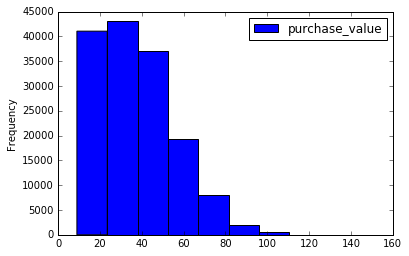

In [8]:
fraud_data[['purchase_value']].plot.hist()

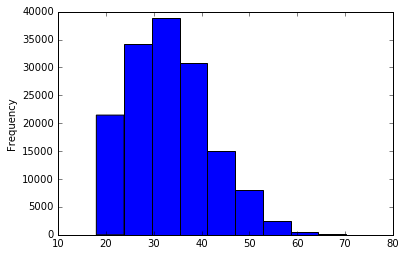

In [9]:
fraud_data['age'].plot.hist()

In [10]:
fraud_data.groupby('sex').count()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,age,ip_address,class
sex,,,,,,,,,,
F,62819,62819,62819,62819,62819,62819,62819,62819,62819,62819
M,88293,88293,88293,88293,88293,88293,88293,88293,88293,88293


In [11]:
fraud_data.groupby('class').count()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address
class,,,,,,,,,,
0,136961,136961,136961,136961,136961,136961,136961,136961,136961,136961
1,14151,14151,14151,14151,14151,14151,14151,14151,14151,14151


Ok, so we see that about 1 in 10 transactions are labeled as fraudulent! 

We also see that the distribution of other features look fairly normal, that **sex** is roughly 40/60 favoring males, while **age** of users also makes sense (no outliers), and **browser** and **source** also look fairly normal.

The **purchase_value** peaks around \$30 and dropps off quickly, with few values beyond \$80. 

Finally, each **user_id** is unique, so the total number of distinct **user_id** = len(**fraud_data**), which is 151,112.

First data engineering item to accomplish is to map out using the IP address what country each transaction happened in. Let's look at the **ip_to_country** data.

In [12]:
ip.head(10)

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China
5,16781312.0,16785407,Japan
6,16785408.0,16793599,China
7,16793600.0,16809983,Japan
8,16809984.0,16842751,Thailand
9,16842752.0,16843007,China


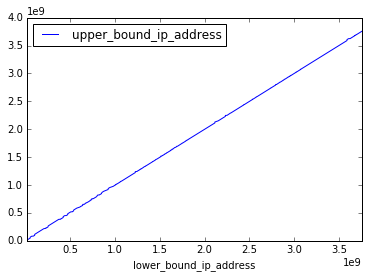

In [13]:
ip.plot('lower_bound_ip_address')

Ok, this table simply gives the ip_address range for each country, and different countries each have multiple zones of ip addresses.

In [14]:
# this code takes few minutes to run...
ip_low = ip['lower_bound_ip_address']
ip_high = ip['upper_bound_ip_address']
ip_country = ip['country']

countries = ['N/A']*len(fraud_data)
for i in range(len(ip_low)):
    for j in np.where( (fraud_data['ip_address'] >= ip_low[i]) & (fraud_data['ip_address'] <= ip_high[i]) )[0]:
        countries[j] = ip_country[i]
        
# countries = pd.Series()
# for i in range(len(fraud_data)):
#     ip_add = fraud_data['ip_address'][i]
#     try:
#         country = ip['country'][ (ip['lower_bound_ip_address'] <= ip_add) \
#                                     & (ip['upper_bound_ip_address'] >= ip_add) ].iat[0]
#     except:
#         country = 'N/A'
#     countries.set_value(i,country)

In [15]:
# Potential quicker methods for finding countries. Still work in progress...

# using pd.searchsorted()
# stacked_countries = np.hstack(['N/A', ip['country'].values, 'N/A'])
# countries_2 = stacked_countries[ ip['lower_bound_ip_address'].head(1).append( \
#                                                         ip['upper_bound_ip_address']).searchsorted(fraud_data.ip_address) ]

# using range join
# fraud = fraud_data.ip_address.values
# ip_h = ip.upper_bound_ip_address.values
# ip_l = ip.lower_bound_ip_address.values
# i, j = np.where( (fraud[:, None] >= ip_l) & (fraud[:, None] <= ip_h) )

# pd.DataFrame(
#             np.column_stack([fraud.values[i], ip.values[j]]),
#             columns=fraud.columns.append(ip.columns))

In [16]:
# append countries to fraud_data
fraud_data['country'] = countries

In [17]:
fraud_data

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,N/A
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada
6,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0,N/A
7,360585,2015-04-06 07:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0,United States
8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0,China
9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0,United States


Ok, our **fraud_data** table is now complete! Let's take a look at some of the countries and their frequencies in the transactions.

In [18]:
fraud_data.groupby('country').count()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
country,,,,,,,,,,,
Afghanistan,6,6,6,6,6,6,6,6,6,6,6
Albania,13,13,13,13,13,13,13,13,13,13,13
Algeria,122,122,122,122,122,122,122,122,122,122,122
Angola,24,24,24,24,24,24,24,24,24,24,24
Antigua and Barbuda,3,3,3,3,3,3,3,3,3,3,3
Argentina,661,661,661,661,661,661,661,661,661,661,661
Armenia,15,15,15,15,15,15,15,15,15,15,15
Australia,1844,1844,1844,1844,1844,1844,1844,1844,1844,1844,1844
Austria,435,435,435,435,435,435,435,435,435,435,435


Wow! Lots of countries are represented in the transaction! It's also important to note that some datapoints have frequencies that lie outside the spectrum specified in **ip** table. These countries are marked as 'N/A'. This completes the first goal of the exercise.

## Feature Engineering
Now, based on the features present in the **fraud_data** table, we try to come up with other features that are more powerful and useful when training our model. 

Some useful features might be:

* **shopping_time**: Time difference between signup_time and purchase_time. A very short shopping time may be a sign of fraudulent transaction.

* **ip_address_count**: Check how many other users have the same ip_address. Multiple ip_addresses shared by many users may be a sign of fraudulent transaction.

* **device_id_count**: Check how many other users have purchased the same device_id. Fraudulent transactions may involve a certain type of device more than others. 

* **day of the week and week of the year time variables**: This captures the time/seasonal dependency of the transaction, which may tell us something about whether or not the activity is likely to be fraudulent or not. 

Let's go ahead and perfrom this feature engineering.

In [19]:
# shopping time
fraud_data['shopping_time'] = pd.to_datetime(fraud_data['purchase_time']) - pd.to_datetime(fraud_data['signup_time'])
fraud_data['shopping_time'] = pd.to_timedelta(fraud_data['shopping_time'],unit='s')/np.timedelta64(1,'s')

In [20]:
# IP address count
fraud_data['ip_address_count'] = fraud_data.groupby('ip_address')['user_id'].transform('count')

# device ID count
fraud_data['device_id_count'] = fraud_data.groupby('device_id')['user_id'].transform('count')

In [21]:
# day of the week
fraud_data['signup_time_dow'] = pd.to_datetime(fraud_data['signup_time']).dt.dayofweek
fraud_data['purchase_time_dow'] = pd.to_datetime(fraud_data['purchase_time']).dt.dayofweek
# week of the year
fraud_data['signup_time_week'] = pd.to_datetime(fraud_data['signup_time']).dt.week
fraud_data['purchase_time_week'] = pd.to_datetime(fraud_data['purchase_time']).dt.week

# review dataset
fraud_data

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,shopping_time,ip_address_count,device_id_count,signup_time_dow,purchase_time_dow,signup_time_week,purchase_time_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,1,1,1,5,9,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,1,1,6,0,23,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,12,12,3,3,1,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,N/A,492085.0,1,1,1,0,18,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,1,1,1,2,30,37
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada,4240931.0,1,1,3,3,21,28
6,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0,N/A,2177825.0,1,1,5,3,31,35
7,360585,2015-04-06 07:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0,United States,4268729.0,1,1,0,0,15,22
8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0,China,3594200.0,1,1,1,1,17,23
9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0,United States,4943753.0,1,1,6,0,4,13


In [22]:
col_list = ['purchase_value','source','browser','sex','age','class','country',
            'shopping_time','ip_address_count','device_id_count','signup_time_dow',
           'purchase_time_dow','signup_time_week','purchase_time_week']
fraud_data = fraud_data[col_list]
fraud_data

,purchase_value,source,browser,sex,age,class,country,shopping_time,ip_address_count,device_id_count,signup_time_dow,purchase_time_dow,signup_time_week,purchase_time_week
0,34,SEO,Chrome,M,39,0,Japan,4506682.0,1,1,1,5,9,16
1,16,Ads,Chrome,F,53,0,United States,17944.0,1,1,6,0,23,24
2,15,SEO,Opera,M,53,1,United States,1.0,12,12,3,3,1,1
3,44,SEO,Safari,M,41,0,N/A,492085.0,1,1,1,0,18,19
4,39,Ads,Safari,M,45,0,United States,4361461.0,1,1,1,2,30,37
5,42,Ads,Chrome,M,18,0,Canada,4240931.0,1,1,3,3,21,28
6,11,Ads,Chrome,F,19,0,N/A,2177825.0,1,1,5,3,31,35
7,27,Ads,Opera,M,34,0,United States,4268729.0,1,1,0,0,15,22
8,30,SEO,IE,F,43,0,China,3594200.0,1,1,1,1,17,23
9,62,Ads,IE,M,31,0,United States,4943753.0,1,1,6,0,4,13


Great, with feature engineering complete, we just need to get the categorical features into dummy numerical variables for input into our machine learning model.

In [23]:
# create dummy variables for categorical features
fraud_dummies = pd.get_dummies(fraud_data,['source','browser','sex','country'])
fraud_dummies

,purchase_value,age,class,shopping_time,ip_address_count,device_id_count,signup_time_dow,purchase_time_dow,signup_time_week,purchase_time_week,...,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
0,34,39,0,4506682.0,1,1,1,5,9,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,16,53,0,17944.0,1,1,6,0,23,24,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,15,53,1,1.0,12,12,3,3,1,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,44,41,0,492085.0,1,1,1,0,18,19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,39,45,0,4361461.0,1,1,1,2,30,37,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,42,18,0,4240931.0,1,1,3,3,21,28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,11,19,0,2177825.0,1,1,5,3,31,35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,27,34,0,4268729.0,1,1,0,0,15,22,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,30,43,0,3594200.0,1,1,1,1,17,23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,62,31,0,4943753.0,1,1,6,0,4,13,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Machine Learning

Now we split the data into test/train set. We know from looking at the **fraud_data** table that the dataset is very imbalanced by a ratio of 10 to 1 (favoring non-fraud activities). Therefore, we need to think about how to approach the ML model and the performance metrics.

There are several ways to deal with imbalanced data.

* **Picking the right ML model**: Usually, decision trees do well on imbalanced data. Ensemble methods, like random forests, do even better. We'll use random forest in this exercise to create the fraud transaction model.


* **Performance metric**: Instead of using accuracy, use other metrics. Because we are concerned with effects of false positives/negatives, we need to look at the confusion matrix and the ROC curve. Also, precision and recall are important for classification performance.


* There are other methods you can use, like gathering more data (not possible in this exercise), resampling the dataset (the imbalance is too large here), using penalized models, etc. But for the purpose of this exercise, we will use the two methods outlined above.

In [26]:
# create test/train datasets by randomly sampling from fraud_dummies
train = fraud_dummies.sample(frac=0.8, random_state=1)
test = fraud_dummies.drop(train.index)
train_x = train.drop('class',1)
train_y = train['class']
test_x = test.drop('class',1)
test_y = test['class']

In [118]:
# fit the random forest model. 50 trees and min leaf size at 0.2% of the total dataset
rf = RandomForestClassifier(n_estimators=50, min_samples_leaf=len(train_x)/500)
fraud_model = rf.fit(train_x, train_y)
y_pred = fraud_model.predict(test_x)

Now let's check the performance of this random forest classifier by performance metrics specified above.

In [119]:
# compare our model train accuracy with majority classifier train accuracy
model_train_score = fraud_model.score(train_x,train_y)
train_maj_classifier_score = len(train_y[train_y==0])/float(len(train_y))
print 'MODEL TRAIN SCORE: ', model_train_score
print 'MAJORITY CLASSIFER TRAIN SCORE: ', train_maj_classifier_score
model_test_score = fraud_model.score(test_x,test_y)
test_maj_classifier_score = len(test_y[test_y==0])/float(len(test_y))
print 'MODEL TEST SCORE: ', model_test_score
print 'MAJORITY CLASSIFER TEST SCORE: ', test_maj_classifier_score

MODEL TRAIN SCORE:  0.956464554554
MAJORITY CLASSIFER TRAIN SCORE:  0.906022003474
MODEL TEST SCORE:  0.957084243266
MAJORITY CLASSIFER TEST SCORE:  0.907683144729


Ok, so our model is a 5% improvement over majority classifier in the test set. What about the confusion matrix?

In [120]:
# confusion matrix
conf_matrix = sklearn.metrics.confusion_matrix(test_y,y_pred)
print 'CONFUSION MATRIX:\n', conf_matrix
print '\nTrue Negatives: ', conf_matrix[0,0]
print 'False Negatives: ', conf_matrix[1,0]
print 'True Positives: ', conf_matrix[1,1]
print 'False Positives: ', conf_matrix[0,1]

CONFUSION MATRIX:
[[27432     0]
 [ 1297  1493]]

True Negatives:  27432
False Negatives:  1297
True Positives:  1493
False Positives:  0


Looks like the model is catching just over half of the fradulent transactions in the test set. The number of false positives, or normal transactions that have been flagged as fradulent, is also very low. Let's look at these numbers in terms of *precision* and *recall*.

In [121]:
# precision and recall: 
# precision = true_pos/(false_pos+true_pos)
# recall = true_pos/(true_pos+false_neg)
fraud_model_precision = conf_matrix[1,1]/float(conf_matrix[0,1]+conf_matrix[1,1])
fraud_model_recall = conf_matrix[1,1]/float(conf_matrix[1,1]+conf_matrix[1,0])
print 'Model Precision: ', fraud_model_precision
print 'Model Recall: ', fraud_model_recall

Model Precision:  1.0
Model Recall:  0.535125448029


We see that our random forest model is very precise, meaning that all the ones it flags as positive (fraudulent) are very likely to be actual fraudulent transactions.

Our recall, on the other hand, is not quite as good, just above 50%. This means the model will capture about half of all the fradulent transactions.

To further tune our random forest model, we can plot the precision-recall curve. But for the purpose of this exercise, we will assume this model is good enough.

Since the exercise asks about effects of false positives/negatives, let's come up with a ROC curve. 

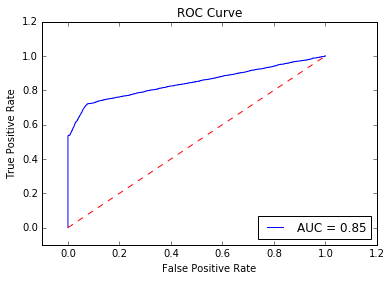

In [122]:
# caculate the ROC curve
y_test_proba = fraud_model.predict_proba(test_x)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(test_y, y_test_proba[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr,tpr,label='AUC = %0.2f'%roc_auc)
plt.plot([0,1],[0,1], color='r', linestyle='--')
plt.legend(loc='lower right')
plt.xlim([-0.1, 1.2])
plt.ylim([-0.1, 1.2])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Ok, AUC of the ROC of 0.85 is not bad. We'd like to see something above 0.9, but this will do for now, since we aren't spending too much time fine-tuning our model.

Based on the ROC, if we cared about minimizing false positives, then we would pick a true positive rate of about ~0.55 and still get a false positive rate of 0. 

But if we want to maximize true positive, then we have to decrease the cutoff. After true positive of around 0.7, the gains become linear (with a fairly shallow slope).

## Exploring the Model Results

Let's look at what features the random forest model deemed to be the most important in our fraud detection model.

In [151]:
# variable importances
var_importances = fraud_model.feature_importances_
ind = np.argsort(var_importances)[::-1]

# variable names
var_names = list(train_x)

# list top 20 variables by their importance
for i in range(20):
    print '\n', i, ': ' 'Variable: ' + var_names[ind[i]], ' Importance: %.3e' %var_importances[ind[i]]


0 : Variable: shopping_time  Importance: 3.387e-01

1 : Variable: device_id_count  Importance: 2.189e-01

2 : Variable: ip_address_count  Importance: 1.644e-01

3 : Variable: purchase_time_week  Importance: 1.609e-01

4 : Variable: signup_time_week  Importance: 6.763e-02

5 : Variable: purchase_time_dow  Importance: 4.052e-03

6 : Variable: signup_time_dow  Importance: 1.426e-03

7 : Variable: source_Direct  Importance: 7.879e-04

8 : Variable: age  Importance: 5.100e-04

9 : Variable: sex_M  Importance: 4.624e-04

10 : Variable: purchase_value  Importance: 4.330e-04

11 : Variable: browser_Chrome  Importance: 3.610e-04

12 : Variable: browser_Safari  Importance: 2.104e-04

13 : Variable: source_Ads  Importance: 1.990e-04

14 : Variable: sex_F  Importance: 1.893e-04

15 : Variable: browser_IE  Importance: 1.347e-04

16 : Variable: source_SEO  Importance: 1.002e-04

17 : Variable: browser_FireFox  Importance: 9.859e-05

18 : Variable: country_Canada  Importance: 5.332e-05

19 : Variabl

([<matplotlib.axis.XTick at 0x3584e4a8>,
 <a list of 5 Text xticklabel objects>)

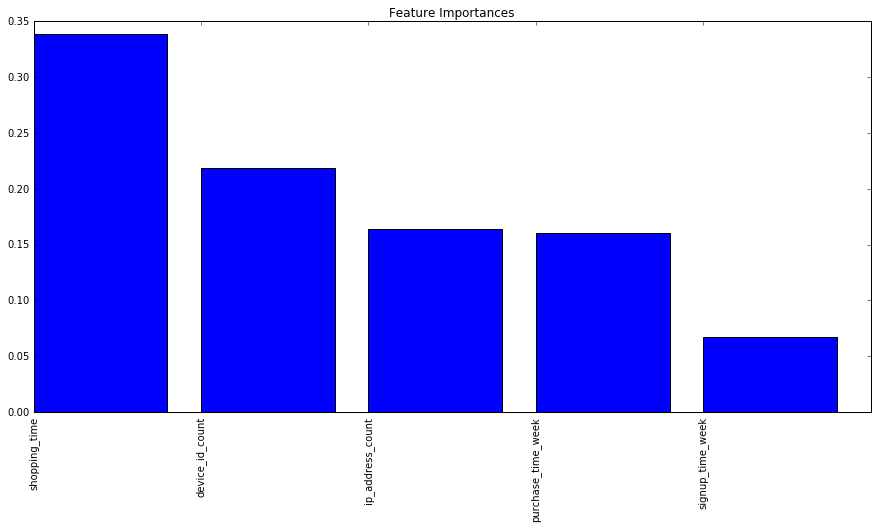

In [182]:
# plot the top X most important features and their weight
X = 5
top_ind = ind[0:X]

plt.figure(figsize=(15,7))
plt.title('Feature Importances')
plt.bar(range(len(top_ind)), var_importances[top_ind])
plt.xticks(range(len(top_ind)), list(var_names[i] for i in top_ind), rotation='vertical')

Looking at the most important feautures, it seems like country, browser, source, etc don't really play a role. In fact, the most telling features of a fraudulent transactions are our derived features like **shopping_time**, **device_id_count**, and **ip_address_count**. So our feature engineering did payoff!

Let's look further into the top 5 features by looking at their partial dependence plots. To do this in Python, however, the classifier must be a gradient boosting model, which RandomForestClassifier is NOT. So we have to fit a new model using GradientBoostingClassifier.

In [197]:
# fit a GradientBoostingClassifier model
gb = GradientBoostingClassifier(n_estimators=50, min_samples_leaf=len(train_x)/500)
fraud_gb_model = gb.fit(train_x, train_y)

['shopping_time', 'device_id_count', 'ip_address_count', 'purchase_time_week', 'signup_time_week']
[2 4 3 8 7]


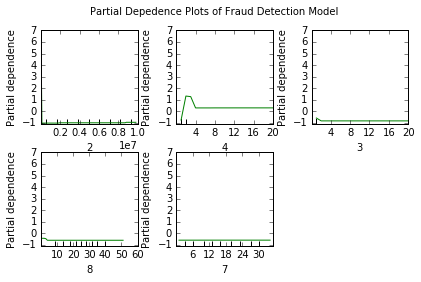

In [227]:
# partial dependence plots
top_var_names = list(var_names[i] for i in top_ind)
print top_var_names
print top_ind
fig, axes = partial_dependence.plot_partial_dependence(fraud_gb_model, train_x, features=top_ind)
fig.suptitle('Partial Depedence Plots of Fraud Detection Model')
plt.subplots_adjust(top=0.9)

From the partial dependence plots, we see that the dependece on shopping time is any transaction less than 1 second. For device and ip_address count, anything more than 1 or 2 counts is a big factor for fraudulent transaction as well. As for time of the week, the weight is towards beginning of the week.

## Conclusion and Recommendations

From the random forest and gradient boosting classifier models and partial dependence plots, we can make the following inferences and conclusions from the data.

* There are 5 important features that determine whether or not a transaction is fradulent. They are in the order of coefficient weights, the following: '**shopping_time**', '**device_id_count**', '**ip_address_count**', '**purchase_time_week**', and '**signup_time_week**'.


* **shopping_time** turns out to the the single most important feature in predicting fraudulent transactions. In fact, many of the fraudulent transactions have shopping time of 1 second or less, meaning some bot or algorithm likely made the purchase. 


* **device_id_count** and **ip_address_count** also are important aspects of a fradulent transaction, as perpetrators are likely to buy certain items in fraudulent transactions and use the same ip address.


* Of the time features, the two relevant features are **purchase_time_week** and **signup_time_week**, both of which slightly favor beginning of the week for fraudulent transactions. One hypothesis for this is that most of those transactions are likely automated and are triggered by some timestamp, perhaps start of the week. 


* Other features did not have significant enough correlation with fraudulent transactions. Country of origin did not matter, and other categorical features like **browser**, **source**, **sex**, etc were not important.

From these inferences from the data and the model, we can make the following business recommendations to our boss about fraudulent transactions and how to implement this model from a product perspective.

* Have the company's e-commerce website continuously calculate the fraudulent transaction probability with the user's inputs when buying the product. And if the risk of fraudulent transaction is greater than some threshold value, the website can ask the user to verify additional information or hold the transaction and flag it for further review. 


* For example, the transaction can be divided into 3 categories:
    1. If predicted fraud probability is small, then the normal transaction can take place with the user. 
    2. If the predicted fraud probabilty is medium, then the website will ask the user for additional verification. This can be some code sent to the user via his email or phone, or similar check.
    3. Finally, if the predicted fraud probability is high, then the website will put the transaction on hold and notify the user that the purchase is under review. If found to be fraudulent, then the website will block the user and his IP address.